In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
torch.manual_seed(1) 
import random

import tqdm
from sklearn.utils import resample
import copy
import pickle

In [0]:
import torch
from torch import nn
from torch import optim
from torch.nn.modules.loss import MSELoss
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data as Data

In [0]:
from sklearn import preprocessing

Код для загрузки данных

In [0]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

class DataGenerator:
    def __init__(self, n_samples=10, n_features=10, collinearity_coef=0, is_normalized=False, is_real=False, ):
        self.n_features = n_features
        self.n_samples = n_samples
        self.collinearity_coef = collinearity_coef
        self.is_normalized = is_normalized
        self.is_real = is_real

    def __nullspace(self, A, atol=1e-13, rtol=0):
        A = np.atleast_2d(A)
        u, s, vh = np.linalg.svd(A)
        tol = max(atol, rtol * s[0])
        nnz = (s >= tol).sum()
        ns = vh[nnz:].conj().T
        return ns

    def generate(self, param):
        if self.is_real:
            pass
        else:
            X = np.zeros((self.n_samples, self.n_features))
            if param["type"] == "rand":
                n_samples = self.n_samples
                n_features = self.n_features
                y = np.random.randint(1.5 * n_samples, size=(n_samples,))
                X[:, :n_features - 1] = np.random.rand(n_samples, n_features - 1)
                X[:, n_features - 1] = y + 0.01 * np.random.randn(n_samples)
                if self.is_normalized:
                    y = y / np.linalg.norm(y)
                    col_norm = np.sqrt(np.sum(X ** 2, axis=0))
                    X = X / col_norm
                return X, y
            elif param["type"] == "inadeq":
                pass
            elif param["type"] == "redund_correl":
                y = np.random.randint(1.5 * self.n_samples, size=(self.n_samples,))
                X_ort_y = self.__nullspace(y)
                k = self.collinearity_coef
                X = k * np.repeat(y.reshape(-1, 1), repeats=self.n_features, axis=1) + \
                    (1 - k) * X_ort_y[:, np.random.randint(X_ort_y.shape[1], size=(self.n_features,))]
                if self.is_normalized:
                    y = y / np.linalg.norm(y)
                    col_norm = np.sqrt(np.sum(X ** 2, axis=0))
                    X = X / col_norm
                return X, y
            elif param["type"] == "adeq_correl":
                n_ort_features = int(np.floor(param["ratio_ort_features"] * self.n_features))
                print("Number of orthogonal features = {0}".format(n_ort_features))
                y = np.random.randint(1.5 * self.n_samples, size=(self.n_samples,))
                y = y / np.linalg.norm(y)
                vec1 = np.zeros((self.n_samples,))
                vec2 = np.zeros((self.n_samples,))
                vec1[0::2] = y[0::2]
                vec2[1::2] = y[1::2]
                X[:, 0] = vec1
                X[:, 1] = vec2
                if n_ort_features < 3:
                    X = X[:, :2]
                else:
                    k = self.collinearity_coef
                    X_ort = self.__nullspace(X[:, :2].T)
                    perm_idx = np.random.randint(X_ort.shape[1], size=(n_ort_features - 2,))
                    X[:, 2:n_ort_features] = X_ort[:, perm_idx]
                    col_norm = np.sqrt(np.sum(X[:, :n_ort_features] ** 2, axis=0))
                    X[:, :n_ort_features] = X[:, :n_ort_features] / col_norm
                    y = X[:, 0] + X[:, 1]
                    n_col_features = self.n_features - n_ort_features
                    print('Number of collinear features = {0}'.format(n_col_features))
                    n_col_feat_per_ort_feat = int(np.floor(n_col_features / n_ort_features))
                    print('Number of collinear features per orthogonal feature = {0}'.format(n_col_feat_per_ort_feat))
                    first_idx = n_ort_features
                    for i in list(range(n_ort_features)):
                        last_idx = first_idx + n_col_feat_per_ort_feat
                        X_ort_current_feat = self.__nullspace(X[:, i])
                        X_ort_current_feat = X_ort_current_feat[:, :n_col_feat_per_ort_feat]
                        #                         X_ort_current_feat = X_ort_current_feat[:, np.random.randint(X_ort_current_feat.shape[1],
                        #                                                                                      size=(n_col_feat_per_ort_feat,))]
                        X[:, first_idx:last_idx] = (1 - k) * X_ort_current_feat + \
                                                   k * np.repeat(X[:, i].reshape(-1, 1),
                                                                 repeats=n_col_feat_per_ort_feat, axis=1)
                        first_idx = last_idx
                if self.is_normalized:
                    col_norm = np.sqrt(np.sum(X ** 2, axis=0))
                    X[:, 2:] = X[:, 2:] / col_norm
                return X, y
def return_dataset(dataset_name,n_samples=2000,n_features=30):
    if dataset_name=='protein':
        casp=pd.read_csv('datasets/CASP.csv')
        X=casp.iloc[:,1:]
        y=casp.iloc[:,0].values
        X=MinMaxScaler().fit_transform(X)
    elif dataset_name=='credit':
        credit=pd.read_csv('datasets/UCI_Credit_Card.csv')
        credit['SEX']=credit['SEX'].replace({2:1,1:0})

        credit=pd.concat([credit,pd.get_dummies(credit['EDUCATION'],prefix='education')],axis=1)

        credit=pd.concat([credit,pd.get_dummies(credit['MARRIAGE'],prefix='marriage')],axis=1)

        y=credit['default.payment.next.month'].values

        X=credit.drop('default.payment.next.month',axis=1)

        X=MinMaxScaler().fit_transform(X)
    elif dataset_name=='wine':
        wine=pd.read_csv('datasets/winequality-white.csv',sep=';')
        y=wine['quality'].values
        X=wine.drop('quality',axis=1)
        X=MinMaxScaler().fit_transform(X)
        y = MinMaxScaler().fit_transform(y.reshape(-1,1)).reshape(1,-1)[0]
    elif dataset_name=='airbnb':
        X=pd.read_csv('train.csv')
        y=pd.read_csv('y_train.csv',names=['target'])['target'].values
        X=MinMaxScaler().fit_transform(X)
        y=MinMaxScaler().fit_transform(y.reshape(-1,1)).reshape(1,-1)[0]
    elif dataset_name=='synthetic':
        is_normalized = False
        collinearity_coef = 0.7
        is_real = False
        dg = DataGenerator(n_samples, n_features, collinearity_coef, is_normalized, is_real)
        rand_par = {"type": "rand"}
        inadeq_correl_par = {}
        redund_correl_par = {"type": "redund_correl"}
        adeq_correl_par = {"type": "adeq_correl", "ratio_ort_features": 0.2}
        X, y = dg.generate(adeq_correl_par)
    return X,y

[Тихоновские матрицы](https://towardsdatascience.com/tikhonov-regularization-an-example-other-than-l2-8922ba51253d)

In [0]:
def L_mat_hf(n_inp,bc = 10):
    L = torch.zeros([n_inp,n_inp], dtype=torch.float32)
    for i in range(0,n_inp):
        lmi = max(0,i-bc)
        lma = min(n_inp,i+bc+1)
        L[i,lmi:lma] = 1.0/(lma-lmi)

    return torch.eye(n_inp, dtype=torch.float32)-L

def L_mat_diff(n_inp):
    L = torch.zeros([n_inp,n_inp], dtype=torch.float32)
    for i in range(1,n_inp-1):
        L[i,i-1] = -1
        L[i,i+1] = 1
    L[0]=-2
    L[1] = 2
    L[-1] = 2
    L[-2] = -2

    return L

Функция считает количество слоев

In [0]:
def get_number_layers(model):
    s = 0
    for layer in model:
        if layer._get_name() == "Linear":
            s += 1
    return s

считает вторую норму произведения матрицы и вектора

In [0]:
def norm_product(tensor_matrix, tensor_vector):
    norm_product = 0
    try:
        product = torch.mv(tensor_matrix,tensor_vector)
        norm_product += torch.norm(product) ** 2
        #print('Its all good')
    except RuntimeError:
        print( 'Something goes wrong')
        print('\n matrix is \n', tensor_matrix, '\n vector is \n',tensor_vector)
    return norm_product    

Общая ошибка, MSE + Ridge + Lasso + количество слоев + частота + разница

In [0]:
class MSE_With_Regularization_Loss(MSELoss):
        def __init__(self, size_average=None, reduce=None, reduction='mean', model = None, Regularization_weights = None):
            super(MSELoss, self).__init__(size_average, reduce, reduction)
            self.model = model
        
        def forward(self, input, target, model, weights):
            
            mse_loss = F.mse_loss(input, target, reduction=self.reduction)
            
            Layer_loss = 0
            Lasso_loss = 0
            Ridge_loss = 0
            High_Frequency_loss = 0
            Local_differences_loss = 0
            Orthogonal_loss = 0
            
            num_layer = 0
            
            for layer in model:
                
                if layer._get_name() == 'Linear':
                    if len(weights['Layers']) > 0:
                        Layer_loss += weights['Layers'][num_layer]                             # написал так, а не просто сумму весов, во-первых, чтобы связь была видна, во-вторых, может мы решим не единичками считать параметры, хз
                    if len(weights['Orthogonal']) > 0:
                        Orthogonal_loss += weights['Orthogonal'][num_layer] * torch.norm(torch.mm(layer.weight, layer.weight.T) - torch.eye(len(layer.weight))) #здесь надо вторую норму WW^T - I
                    for parameter in layer.weight: 
                        
                        #print('Layer is', layer)
                        #print('weight is', layer.weight)
                        #print('Parameter is', parameter)
                        
                        if len(weights['Lasso']) > 0:
                            Lasso_loss += torch.sum(abs(parameter)) * weights['Lasso'][num_layer]
                        if len(weights['Ridge']) > 0:
                            Ridge_loss += torch.sum(parameter ** 2) * weights['Ridge'][num_layer]
                        
                        if len(parameter) > 1:
                            frequency_matrix = L_mat_hf(len(parameter))
                            difference_matrix = L_mat_diff(len(parameter))
                            
                            if len(weights['High Frequency']) > 0:
                                High_Frequency_loss += norm_product(frequency_matrix, parameter) * weights['High Frequency'][num_layer]
                            if len(weights['Local differences']) > 0:
                                Local_differences_loss += norm_product(difference_matrix, parameter ) * weights['Local differences'][num_layer]

                    num_layer += 1
                    
            Regularization_loss = Layer_loss + Lasso_loss + Ridge_loss + High_Frequency_loss + Local_differences_loss + Orthogonal_loss
            
            return mse_loss, Regularization_loss


Класс сети

In [0]:
class Net:
    def __init__(self,val,train,iterations=50,generation_size=50,num_epoch=100,batch_size=300, Regularization = None):
        self.x_val = torch.from_numpy(val[0]).float()
        self.y_val = torch.from_numpy(val[1].reshape(val[0].shape[0],1)).float()
        
        self.x = torch.from_numpy(train[0]).float()
        self.y = torch.from_numpy(train[1].reshape(train[0].shape[0],1)).float()
        self.iterations=iterations
        self.num_epoch=num_epoch
        self.batch_size=batch_size
        self.Regularization = Regularization
    
    def get_ae_model(self,neurons,input_shape):
        net = torch.nn.Sequential()
        for name,q in enumerate(neurons):
            prev=neurons[name-1]
            curr=neurons[name]
            if name==0:
                prev=input_shape
            layer=torch.nn.Linear(prev,curr)
            torch.nn.init.xavier_normal_(layer.weight)
            net.add_module('hidden_'+str(name),layer)
            if name == len(neurons)-1:
                continue
            else:
                net.add_module('hidden_act_'+str(name),torch.nn.ReLU())
        
        return net
    
    def fit_net(self,net,batch_size,num_epochs,X,Y):
        #training_losses,testing_losses = [],[]
        filter(lambda p: p.requires_grad,net.parameters())
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,net.parameters()),lr=0.001, eps=1e-08, weight_decay=0.0)
        
        regularization_weights = self.Define_weights(net)
        
        target_losses = []
        regularization_losses = []

        loss_func = MSE_With_Regularization_Loss()
        torch_dataset = Data.TensorDataset(X,Y)
        loader = Data.DataLoader(
            dataset=torch_dataset, 
            batch_size=batch_size, 
            shuffle=True, num_workers=2)
        for epoch in tqdm.tqdm_notebook(range(num_epochs)):
            for step, (batch_x, batch_y) in enumerate(loader): # for each training step
                #running_loss = 0
                b_x = Variable(batch_x)
                b_y = Variable(batch_y)
                prediction = net(b_x)     # input x and predict based on x
                target_loss, regularization_loss = loss_func(prediction, b_y, net, regularization_weights)     # must be (1. nn output, 2. target, 3. model, 4. weights of regularization)
                loss = target_loss + regularization_loss
                optimizer.zero_grad()   # clear gradients for next train
                loss.backward()         # backpropagation, compute gradients
                optimizer.step()        # apply gradients
                #running_loss += loss.item()
                #training_losses.append(running_loss)

                #with torch.no_grad():
                    #net.eval()
                    #test_loss =0
                    #preds = net(X_val)
                    #loss = loss_func(preds,Y_val)
                target_losses.append(target_loss)
                regularization_losses.append(regularization_loss)
        losses = [target_losses, regularization_losses]
        #print('reg_losses are', regularization_losses)
        return net, losses
    
    def Define_weights(self,net):
        #print('net is ', net)
        lasso_weights = []
        ridge_weights = []
        high_freq_weights = []
        diff_weights = []
        Orthogonal_weights = []
        layer_weights = []
        number_layers = get_number_layers(net)
        
        #print ('number_layers is ',number_layers)
        
        if 'Layers' in self.Regularization:
            layer_weights = torch.ones(size = (number_layers,)) #* 100
        if 'Lasso' in self.Regularization:
            lasso_weights = torch.ones(size = (number_layers,)) #* 100
        if 'Ridge' in self.Regularization:
            ridge_weights = torch.ones(size = (number_layers,)) #* 100
        if 'High Frequency' in self.Regularization:
            high_freq_weights = torch.ones(size = (number_layers,)) # * 100
        if 'Local difference' in self.Regularization:
            diff_weights = torch.ones(size = (number_layers,))# * 100
        if 'Orthogonal' in self.Regularization:
            Orthogonal_weights = torch.ones(size = (number_layers,)) #* 100
            
        regularization_weights = { 'Layers' : layer_weights,         # штраф за количество слоев
                                   'Lasso' : lasso_weights,          # L1 регуляризация
                                   'Ridge' : ridge_weights,        #L2 реугляризация
                                   'High Frequency': high_freq_weights,         # штраф за часто встречающиеся веса
                                   'Local differences': diff_weights,      # штраф за большую разницу в весах
                                    'Orthogonal' : Orthogonal_weights}
        #print ('Regularization weights are', regularization_weights)
        return regularization_weights
        

    def Regularization_optimizer(self,mode):
        #print(self.x.shape[1]//2)
        loss_func = MSE_With_Regularization_Loss()
        #print(self.Regularization)
        
        if mode == 'AE':
            fitted_net, net_losses=self.fit_net(self.get_ae_model([self.x.shape[1]//2,self.x.shape[1]//2,self.x.shape[1]],\
                            self.x.shape[1]),self.batch_size,self.num_epoch,self.x,self.x)
        elif mode == 'dense':
            fitted_net, net_losses=self.fit_net(self.get_ae_model([self.x.shape[1]//2,self.x.shape[1]//2,1],\
                                        self.x.shape[1]),self.batch_size,self.num_epoch,self.x,self.y )
        
        #regularization_weights = self.Define_weights(fitted_net)
        
        
        #first_error=loss_func(fitted_dense(self.x_val),self.y_val, fitted_net, regularization_weights)
        #init_net=pickle.loads(pickle.dumps(fitted_dense))
        
        
        
        #optimized_net,error,masks=self.optimize_net(fitted_dense)
        #return init_net,optimized_net,first_error,error,masks
        return fitted_net, net_losses

In [0]:
dataset = 'airbnb'

In [0]:
print('PROCESS DATASET : '+dataset)
X,y = return_dataset(dataset)
X_train,Y_train=X[:int(len(X)*0.6)],y[:int(len(X)*0.6)]
X_val,Y_val=X[int(len(X)*0.6):int(len(X)*0.8)],y[int(len(X)*0.6):int(len(X)*0.8)]
X_test,Y_test=X[int(len(X)*0.8):],y[int(len(X)*0.8):]

regul = ['Lasso']
test = Net((X_val,Y_val),(X_train,Y_train),batch_size=100,num_epoch=60, Regularization=regul)

trained_ae, ae_losses=test.Regularization_optimizer(mode = 'AE')
trained_net, net_losses=test.Regularization_optimizer(mode = 'dense')

x_after_ae = trained_ae(torch.from_numpy(X_train).float())

y_pred = trained_net(torch.from_numpy(X_test).float())

PROCESS DATASET : airbnb


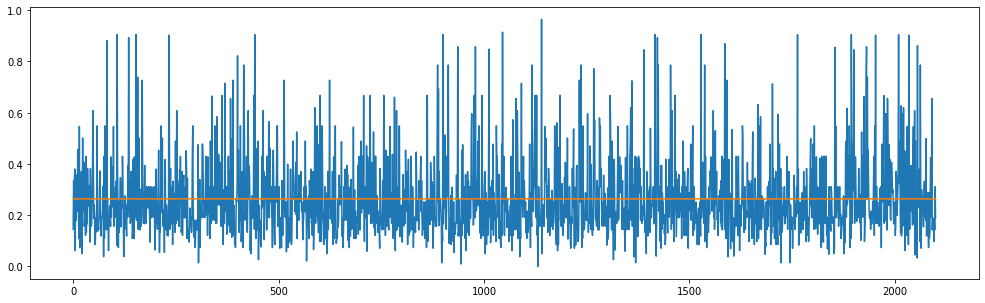

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(17,5))
plt.plot(Y_test)
plt.plot(y_pred.cpu().detach().numpy())
plt.show()

In [0]:
x_after_ae = trained_ae(torch.from_numpy(X_train).float())

In [0]:
x_after_ae

tensor([[0.0000, 0.0000, 0.1412,  ..., 0.7796, 0.2171, 0.0000],
        [0.0000, 0.0000, 0.1412,  ..., 0.7796, 0.2171, 0.0000],
        [0.0000, 0.0000, 0.1412,  ..., 0.7796, 0.2171, 0.0000],
        ...,
        [0.0000, 0.0000, 0.1412,  ..., 0.7796, 0.2171, 0.0000],
        [0.0000, 0.0000, 0.1412,  ..., 0.7796, 0.2171, 0.0000],
        [0.0000, 0.0000, 0.1412,  ..., 0.7796, 0.2171, 0.0000]],
       grad_fn=<ReluBackward0>)

In [0]:
x_after_ae.unique()

tensor([0.0000, 0.0026, 0.0186, 0.0296, 0.0333, 0.0363, 0.1412, 0.1543, 0.2171,
        0.5514, 0.7796, 0.8457], grad_fn=<NotImplemented>)

In [0]:
y_pred = trained_net(torch.from_numpy(X_test).float())

In [0]:
Y_test

array([ 80., 160., 144., ...,  79., 150.,  99.])

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

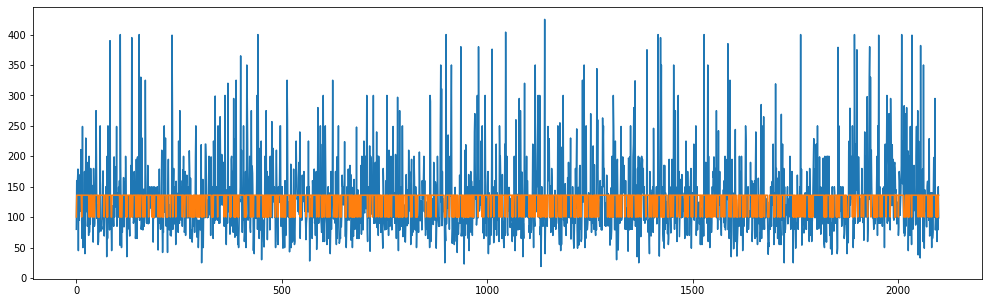

In [0]:
plt.figure(figsize=(17,5))
plt.plot(Y_test)
plt.plot(y_pred.detach().numpy())
plt.show()

In [0]:
unique_data = [list(x) for x in set(tuple(x) for x in x_after_ae[:10])]

In [0]:
unique_data

[[tensor(0., grad_fn=<SelectBackward>),
  tensor(0.1387, grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0.4926, grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0.0347, grad_fn=<SelectBackward>),
  tensor(0.2460, grad_fn=<SelectBackward>),
  tensor(0.8450, grad_fn=<SelectBackward>),
  tensor(0.1556, grad_fn=<SelectBackward>),
  tensor(0.7792, grad_fn=<SelectBackward>),
  tensor(0.2175, grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>)],
 [tensor(0., grad_fn=<SelectBackward>),
  tensor(0.1387, grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0., grad_fn=<SelectBackward>),
  tensor(0.4926, grad_fn=<SelectBackward>),

In [0]:
np.unique(np.array(X_train))

array([0.        , 0.00191571, 0.00201613, ..., 0.97994382, 0.98551663,
       1.        ])

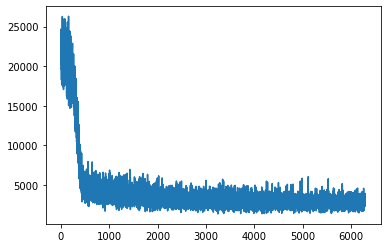

In [0]:
oplt.plot(net_losses[0])

tensor(5785.0820, grad_fn=<AddBackward0>)


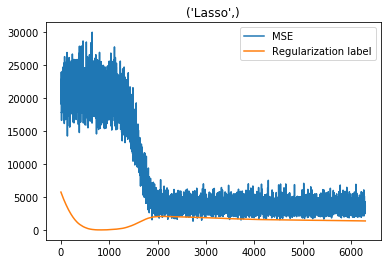

tensor(4511.4336, grad_fn=<AddBackward0>)


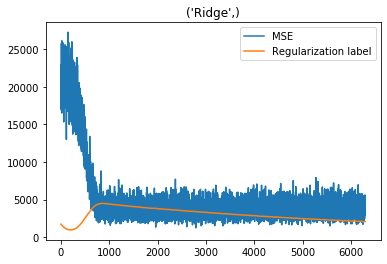

tensor(1610.0770, grad_fn=<AddBackward0>)


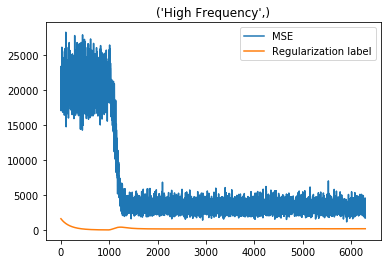

0


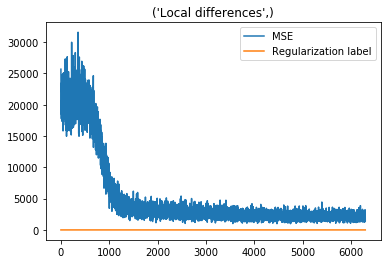

tensor(538.1135, grad_fn=<AddBackward0>)


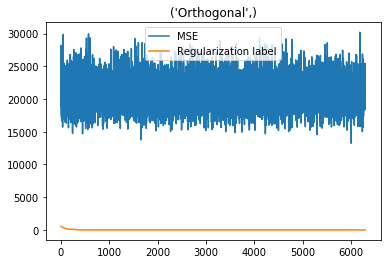

tensor(7878.2407, grad_fn=<AddBackward0>)


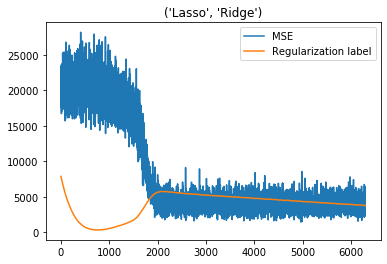

tensor(7455.0293, grad_fn=<AddBackward0>)


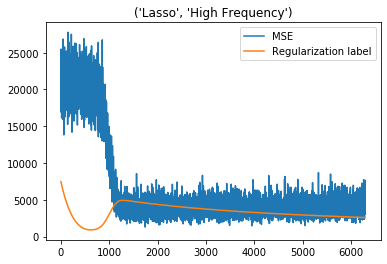

tensor(4953.5015, grad_fn=<AddBackward0>)


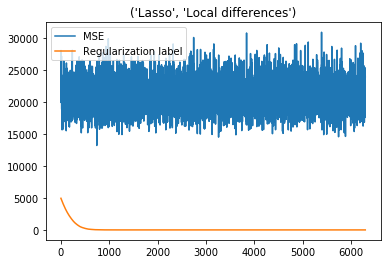

tensor(5312.3823, grad_fn=<AddBackward0>)


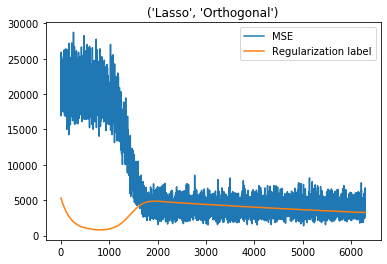

tensor(5403.4414, grad_fn=<AddBackward0>)


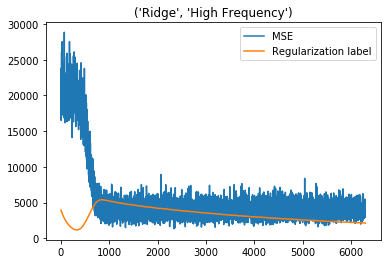

tensor(4367.4160, grad_fn=<AddBackward0>)


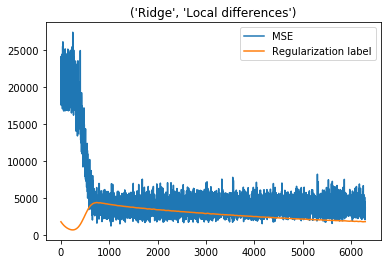

tensor(6433.0400, grad_fn=<AddBackward0>)


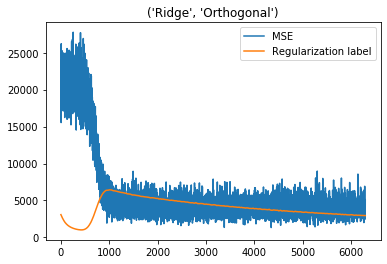

tensor(1822.6111, grad_fn=<AddBackward0>)


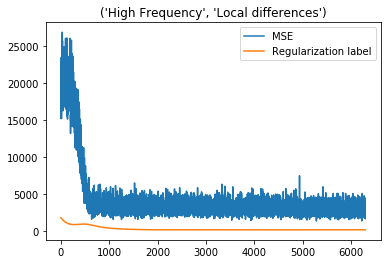

tensor(5754.5205, grad_fn=<AddBackward0>)


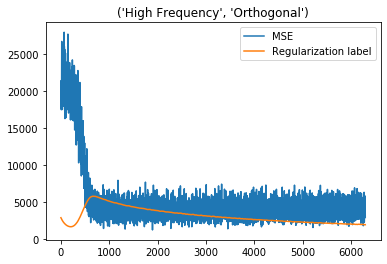

tensor(4285.4268, grad_fn=<AddBackward0>)


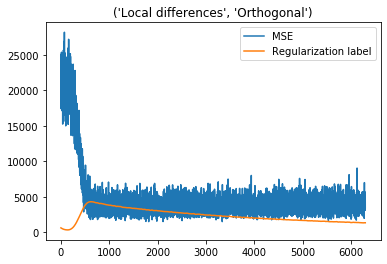

tensor(9142.1602, grad_fn=<AddBackward0>)


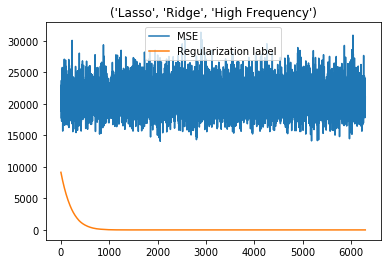

tensor(7512.5205, grad_fn=<AddBackward0>)


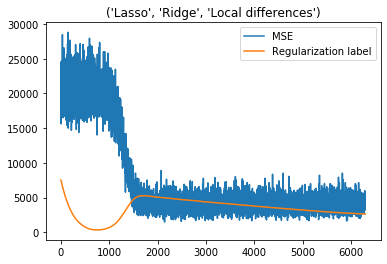

tensor(8919.6699, grad_fn=<AddBackward0>)


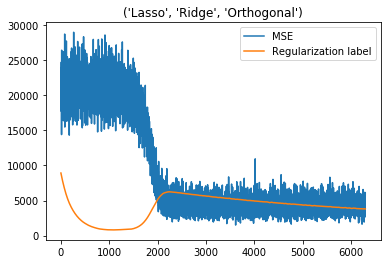

tensor(6466.1885, grad_fn=<AddBackward0>)


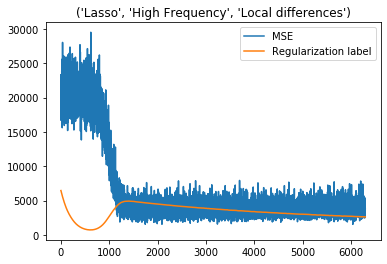

tensor(7824.6748, grad_fn=<AddBackward0>)


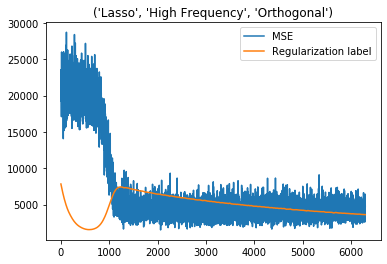

tensor(5729.1885, grad_fn=<AddBackward0>)


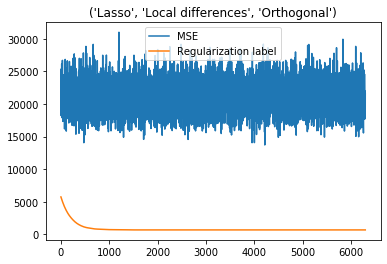

tensor(4091.6970, grad_fn=<AddBackward0>)


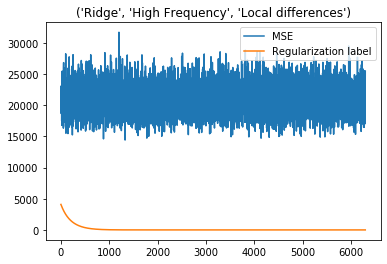

tensor(4021.5093, grad_fn=<AddBackward0>)


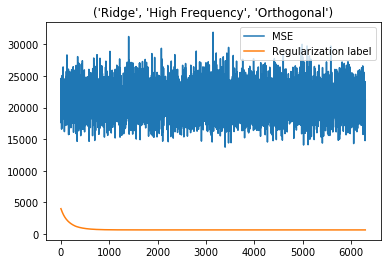

tensor(6802.6787, grad_fn=<AddBackward0>)


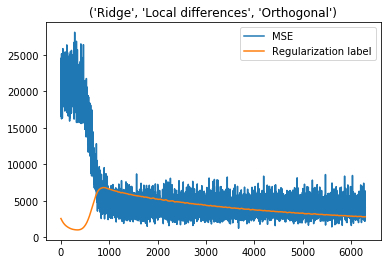

tensor(5433.2393, grad_fn=<AddBackward0>)


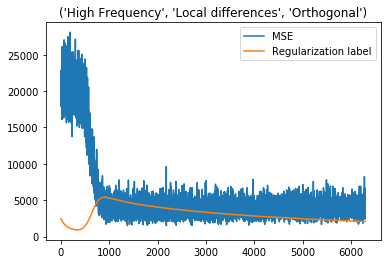

tensor(9273.0215, grad_fn=<AddBackward0>)


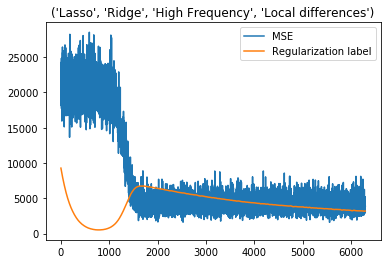

tensor(7854.7817, grad_fn=<AddBackward0>)


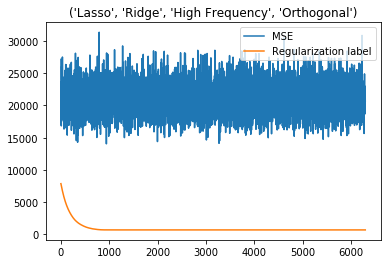

tensor(7506.1411, grad_fn=<AddBackward0>)


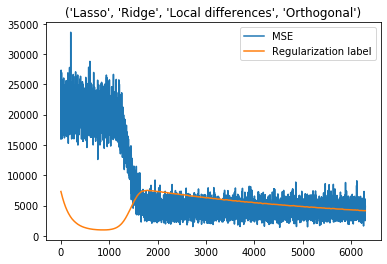

tensor(7920.5557, grad_fn=<AddBackward0>)


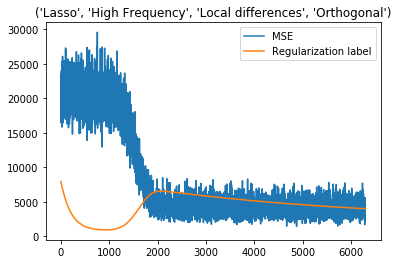

tensor(6913.9941, grad_fn=<AddBackward0>)


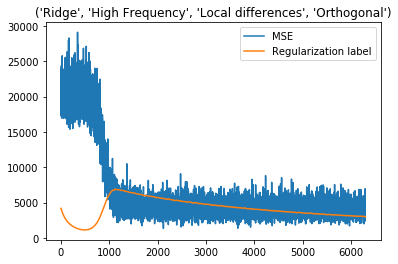

tensor(8611.9062, grad_fn=<AddBackward0>)


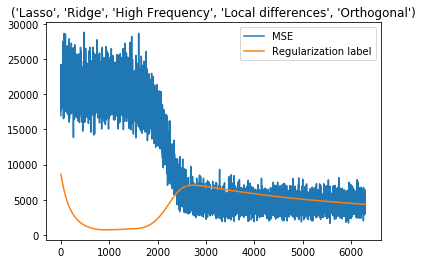

In [0]:
import itertools
Regularization = ['Lasso','Ridge', 'High Frequency','Local differences', 'Orthogonal']
for i in range(5):
  for reg in itertools.combinations(Regularization, i+1):
      test = Net((X_val,Y_val),(X_train,Y_train),batch_size=100, Regularization=reg)
      _, net_losses=test.Regularization_optimizer(mode = 'dense')
      plt.plot (net_losses[0], label = 'MSE')
      plt.plot (net_losses[1], label = 'Regularization label')
      plt.legend()
      print(max(net_losses[1]))
      plt.title (reg)
      plt.show()